In [2]:
import numpy as np

# Parameters

In [103]:
N = 500
m = 3
s = 2
T = 100
r = 4
L = -0.1 
step = 100

# Make Necessary Functions
### Strategy books: FSS and RSS.
### X[t] and mu[t] and S[t] D[t] denpend on the t-1 step and some other parameters.

In [5]:
#FSS:
def FSS(m):
    P = 2**m
    a = [1,-1]
    sb = np.zeros([2**P,P],dtype=int)
    def generate_permutations(length, current_permutation=[]):
        if length == 0:
            yield current_permutation
        else:
            for value in a:
                for permutation in generate_permutations(length - 1, current_permutation + [value]):
                    yield permutation

    all_permutations = np.array(list(generate_permutations(P)))
    return all_permutations

print(FSS(m))
        

[[ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1 -1  1]
 ...
 [-1 -1 -1 ... -1  1 -1]
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1 -1]]


In [60]:
#RSS
def RSS(m):
    a = np.array([[1,1,1,1,1,1,1,1],
                  [-1,-1,-1,-1,1,1,1,1],
                  [-1,-1,1,1,-1,-1,1,1],
                  [1,1,-1,-1,-1,-1,1,1],
                  [1,-1,-1,1,1,-1,-1,1],
                  [1,-1,-1,1,-1,1,1,-1],
                  [-1,1,1,-1,-1,1,1,-1],
                  [-1,1,-1,1,-1,1,-1,1]
                  ])
    b = np.zeros([8,8],dtype=int)
    for i in range(8):
        for j in range(8):
            if a[i][j] ==1:
                b[i][j]=-1
            elif a[i][j]==-1:
                b[i][j]=1
    RSS_strategy_book = np.vstack((a,b))
            
    return RSS_strategy_book

'''
def RSS(m):
    P = 2**m
    origin = FSS(m)
    RSS_sb = np.array([origin[0]])
    RSS_sb[0] = origin[0]
    def if_inco(a,b):
        eq_n = 0
        for i in range(len(a)):
            if a[i] == b[i]:
                eq_n += 1
            else:
                pass
        if eq_n == int(len(a)/2):
            return True
        else:
            return False

    for s_ori in origin:
        judge = True
        for s_cho in RSS_sb:
            if if_inco(s_ori, s_cho):
                judge = judge*True
            else:
                judge = judge*False
        if judge:
            RSS_sb = np.vstack((RSS_sb,s_ori))
            if len(RSS_sb) == P:
                break
        else:
            pass
    anti_RSS_sb = RSS_sb*(-1)
    RSS_sb = np.vstack((RSS_sb,anti_RSS_sb))
    return RSS_sb
    
'''       


'\ndef RSS(m):\n    P = 2**m\n    origin = FSS(m)\n    RSS_sb = np.array([origin[0]])\n    RSS_sb[0] = origin[0]\n    def if_inco(a,b):\n        eq_n = 0\n        for i in range(len(a)):\n            if a[i] == b[i]:\n                eq_n += 1\n            else:\n                pass\n        if eq_n == int(len(a)/2):\n            return True\n        else:\n            return False\n\n    for s_ori in origin:\n        judge = True\n        for s_cho in RSS_sb:\n            if if_inco(s_ori, s_cho):\n                judge = judge*True\n            else:\n                judge = judge*False\n        if judge:\n            RSS_sb = np.vstack((RSS_sb,s_ori))\n            if len(RSS_sb) == P:\n                break\n        else:\n            pass\n    anti_RSS_sb = RSS_sb*(-1)\n    RSS_sb = np.vstack((RSS_sb,anti_RSS_sb))\n    return RSS_sb\n    \n'

In [84]:
#D(t):
def D(strategy):
    '''
    strategy is a list with length N and conponents -1, 1 or 0.
    '''
    D_t = sum(strategy)
    return D_t
    



#X(t) from t-1 step:
def lnX(lnx_tm1, strategy):
    _lambda_ = np.count_nonzero(strategy)
    lnx_t = lnx_tm1 +D(strategy)/_lambda_
    return lnx_t

In [89]:
#mu(t):
def mu(mu_tm1, strategy, L, P):
    def H(x):
        return 1 if x >= 0 else 0
    _lambda_ = np.count_nonzero(strategy)
    mu = 2*mu_tm1 - P*H(mu_tm1-P*0.5)+H(D(strategy)/_lambda_-L)
    return mu

#S(t):
def S(T,S_tm1, a, strategy, L):
    _lambda_ = np.count_nonzero(strategy)
    if _lambda_ ==0:
        S = (1-1/T)*S_tm1
    else:
        S = (1-1/T)*S_tm1 - a*(D(strategy)/_lambda_-L)
    sigma = np.sqrt(1/(1-(1-1/T)**2))
    S_random = np.random.normal(S, sigma)
    return S_random

In [18]:
#strategy books chosen by agents:
#choose randomly and unchanged:
def choose_sb(strategy_books, N, s):
    import random
    n_sb = np.shape(strategy_books)[0]
    index_sb = set(np.arange(n_sb))
    strategy_hold = np.zeros([N,s], dtype=int)
    for i in range(N):
        strategy_hold[i] = np.array(random.sample(index_sb, s))
    return strategy_hold
    

# Steps to participate in the buy/sell game for evey agent( I am an agent!)
- I am at t now before I need to decide to buy or sell! What can I see: mu[t], decisions that other agents did at t-1.
- I check my strategy books, s strategy books are used. I don't want to change them.
- I see the mu[t], and strategy books give me s behaviors that I can act at t, or I can chooce to skip over. How should I decide?
- I see the S[t] of each of my strategy books, which can be calculated by S[t-1] and decisions that other agents did at t-1. 
- I see the max S[t], and see if it is more than r? If so, I will choose the related strategy book, and obey the behavior it offers me. If not, I won't participate in!
- Every agent like me will do the same steps, then there will be a decision list done by everyone at t. New X[t+1], mu[t+1]...
- I go to the t+1, and everything continue...

In [75]:
def buy_sell_game(t_end):
    global N, m, s, r, T, L
    index_N = np.arange(N)
    t_range = np.arange(0,t_end)
    strategy_books = RSS(m)
    strategy_hold = choose_sb(strategy_books, N, s)
    lnX_list = np.zeros(t_end)
    lnX_list[0] = 1
    mu_list = np.zeros(t_end, dtype = int)
    mu_list[0] = 0
    Score = np.zeros([N,s], dtype=float)#初始化S
    strategy = np.zeros([N,t_end], dtype=int)#初始化strategy
    for t in t_range:
        if t==0:
            for n in index_N:
                for index_s in range(s):
                    strategy_index = strategy_hold[n][index_s]
                    strategy_s = strategy_books[strategy_index]
                    Score[n][index_s] = S(T,Score[n][index_s], strategy_s[mu_list[t]], [], L)
                Score_max_index = np.argmax(Score[n])
                Score_max = Score[n][Score_max_index]
                if Score_max>=r:
                    strategy_index_chosen = strategy_hold[n][Score_max_index]#选择最大分数的策略
                    strategy_s_chosen = strategy_books[strategy_index_chosen][mu_list[t]]
                    strategy[n,0] = strategy_s_chosen
                else:
                    strategy[n,0] = 0#不参加
        else:
            lnX_list[t] = lnX(lnX_list[t-1], strategy[:,t-1])
            mu_list[t] = mu(mu_list[t-1], strategy[:,t-1], L, 2**m)
            for n in index_N:
                for index_s in range(s):
                    strategy_index = strategy_hold[n][index_s]
                    strategy_s = strategy_books[strategy_index]
                    Score[n][index_s] = S(T,Score[n][index_s], strategy_s[mu_list[t]], strategy[:,t-1], L)
                Score_max_index = np.argmax(Score[n])
                Score_max = Score[n][Score_max_index]
                if Score_max>=r:
                    strategy_index_chosen = strategy_hold[n][Score_max_index]#选择最大分数的策略
                    strategy_s_chosen = strategy_books[strategy_index_chosen][mu_list[t]]
                    strategy[n,t] = strategy_s_chosen
                else:
                    strategy[n,t] = 0#不参加
    return lnX_list, strategy


    

In [98]:
lnX_list,strategy=buy_sell_game(step)

Text(0.5, 1.0, 'X-t')

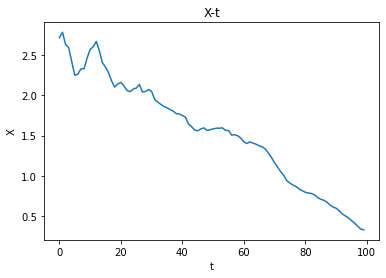

In [99]:
#plot figures
import matplotlib.pyplot as plt
t_range = np.arange(0,step)
plt.plot(t_range, np.exp(lnX_list))
plt.xlabel('t')
plt.ylabel('X')
plt.title('X-t')

Text(0.5, 1.0, 'V-t')

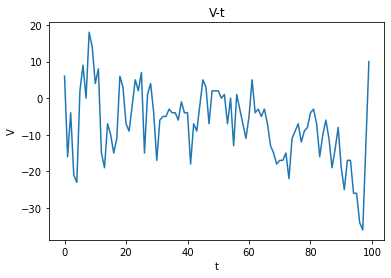

In [100]:
plt.plot(t_range,sum(strategy))
plt.xlabel('t')
plt.ylabel('V')
plt.title('V-t')

# Culculate some statistical results
- N_active
- the distribution of Deltax
- the correlation between Deltax and x itself

In [101]:
# N_active
def plot_N_active(strategy):
    N_active_list = np.zeros(100)
    for t in range(100):
        strategy_i = strategy[:,t]
        N_active_list[t] = np.count_nonzero(strategy_i)
    t_range = np.arange(100)
    plt.bar(t_range, N_active_list, align='center', alpha = 0.5)
    plt.xlabel('t')
    plt.ylabel('N_active')
    plt.title('N_active-t plot')
    plt.show()


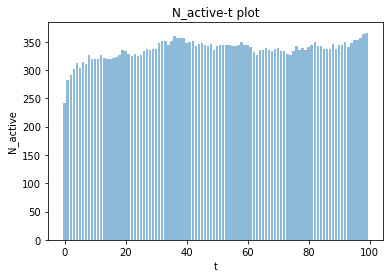

In [102]:
plot_N_active(strategy)

In [120]:
# distribution
def distribution(x_list):
    delta_x_list = np.zeros(step-1)
    for i in range(step-1):
        delta_x_list[i] = x_list[i+1] - x_list[i]
    delta_x_min = min(delta_x_list)
    delta_x_max = max(delta_x_list)
    d_deltax = (delta_x_max-delta_x_min)/30
    delta_x_range = np.linspace(delta_x_min,delta_x_max, 30)
    distribute_n = np.zeros(30)
    for i in range(29):
        dx_min = delta_x_range[i]
        dx_max = delta_x_range[i+1]
        delta_x_list_copy = delta_x_list[:]
        for deltax in delta_x_list_copy:
            if (deltax>=dx_min) and (deltax<dx_max):
                distribute_n[i]+=1#落在区间的计数
                delta_x_list = np.delete(delta_x_list, np.where(delta_x_list == deltax))#删掉计数的
            else:
                pass
    distribute_n[-1] = len(delta_x_list)#剩下的
    plt.bar(delta_x_range, distribute_n, width=d_deltax, align='center', alpha = 0.5)
    plt.xlabel('delta_x')
    plt.ylabel('p(delta_x)')
    plt.title('distribution of deltax')
    plt.show()

            


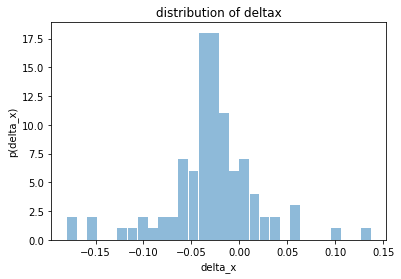

In [121]:
distribution(np.exp(lnX_list))

In [ ]:
#correlation function
